### **(?): shows where you need to write code**

### (?) Go to the location of the data

Mount the notebook to your google drive, and then you can access the files in google drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

**(?) Switch to the corona folder**

command: %cd /content/drive/MyDrive/.../corona

'...' means the path from 'MyDrive' to the 'corona' folder, which needs to be filled in according to where you put the 'corona' folder

In [ ]:
%cd /content/drive/MyDrive/

**Check if the directory is correct**

If correct, you will find "data", "corona_questions", and "corona.ipynb" in the output

In [ ]:
!ls

### (?) (optional) Package

**Import packages**

In [1]:
import numpy as np
from scipy.io import loadmat, savemat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from pathlib import Path
import math

import os
import time
import datetime
import matplotlib.pyplot as plt

import cv2

**(?) (optional) Other packages**

If you want to use some packages that are not imported above, please write in the block below; if not, you can ignore this block

### (?) Data

> In this project, the model is designed for complex-valued video, you need to read the file and treat it as a complex-valued video, whether it is a complex-valued video or a real-valued video, and then store it as real-valued data

> In the data folder, there are 9 MAT files, and each file has three 3D arrays of size (H,W,T<sub>total</sub>):
> * D: raw data, original video
> * L: low rank part, background
> * S: sparse part, foreground
>
> where H is the height of the frame, W is the width of the frame, and T<sub>total</sub> is the total number of frames in the video. Also, the frame size has been resized to 100*100 (meaning H = W = 100)

**(?) Read files and Get data**

Description: You already know the location of the files containing the videos, please read them and gather and organize the data.

Requirements:
1. You need to sample a continuous segment of length T (num_frames in the code) from the video every few frames (stride in the code), each segment of size (H,W,T)
2. Because the model only accepts real-valued data, and the segment is complex-valued, it is necessary to concatenate the real and imaginary parts of the video along the third dimension.
 * Size changed from (H,W,T) to (H,W,T2), where T2 = T × 2, the first T 2D arrays are the real part of the segment, and the last T 2D arrays are the imaginary part of the segment
3. Function I/O
 * Input: A MAT file, num_frames, stride
 * Output: D, L, S (the size should be (N,1,H,W,T2), where N is the number of segments of size (H,W,T2))

Hint:
* Given a tensor A of size (H,W,T), what is the size of B = A[None, ...]?

In [2]:
def get_data(file, num_frames=40, stride=10):
    data = loadmat(file, mat_dtype=True)
    D, L, S = data["D"], data["L"], data["S"]
    D = D.astype(np.complex64)

    segments = []
    for i in range(0, D.shape[2] - num_frames + 1, stride):
        segment_D = D[:, :, i:i + num_frames]
        segment_L = L[:, :, i:i + num_frames]
        segment_S = S[:, :, i:i + num_frames]
        segments.append((segment_D, segment_L, segment_S))

    segments = np.array(segments)

    segments_complex = segments.astype(np.complex64)
    segments_real = np.real(segments_complex)
    segments_imag = np.imag(segments_complex)
    segments_concat = np.concatenate((segments_real, segments_imag), axis=-1)

    return torch.from_numpy(np.expand_dims(segments_concat[:, 0], axis=1)), torch.from_numpy(np.expand_dims(segments_concat[:, 1], axis=1)), torch.from_numpy(np.expand_dims(segments_concat[:, 2], axis=1))
# get_data('data/Board.mat')

**(?) Build a custom dataset using the data you get from 'get_data'**

Requirement:
1. You now get D, L, S, please build a custom dataset for loading data

Note:
1. Image transformation is not necessary, it's up to you

In [3]:
class CustomDataset(Dataset):
    def __init__(self, D, L, S, transform=None):
        self.D, self.L, self.S = D, L, S
        self.transform = transform

    def __len__(self):
        return len(self.D)

    def __getitem__(self, index):
        x = self.D[index],
        y = (self.L[index], self.S[index])

        if self.transform:
            x = self.transform(x)

        return x, y

### (?) Model

> You'll be writing code for soft thresholding in your model, so here's a brief description of what soft thresholding is and how to use it
>
> * Hard thresholding will turn values close to 0 directly to 0, while soft thresholding will move all values closer to 0 (too close will directly become 0)
>
> * Using a soft threshold with $ℓ_1$-norm can make variables sparse, in practice you can often see many people use it because $ℓ_1$-norm has good properties (convex, continuous, sub-differentiable)
>
> * Suppose now you have a variable $x$ (scalar or vector) and a threshold $t \geq 0$, you can do soft thresholding on $x$ as follows:
>
>  1. Change $x = ||x||_2 × \frac{x}{||x||_2}$, the first part shows the magnitude and the second part shows the direction
>  2. We do the thresholding on the magnitude, so change the magnitude to ReLU$(||x||_2 - t)$
>  3. The result $x'=$ ReLU$(||x||_2 - t) × \frac{x}{||x||_2} = (||x||_2 - t)_{+} × \frac{x}{||x||_2}$
> * From the above example, you can find that the most important thing is to find an appropriate threshold $t$, which is what we want the model to learn
>

**(?) Complex Convolutional 3D Layer**

From the equation:

Y = X × W \\
= Y<sub>real</sub> + jY<sub>imag</sub>
= (X<sub>real</sub> + jX<sub>imag</sub>) × (W<sub>real</sub> + jW<sub>imag</sub>) \\
= X<sub>real</sub> × W<sub>real</sub> + X<sub>real</sub> × jW<sub>imag</sub> + jXi × W<sub>real</sub> + jX<sub>imag</sub> × jW<sub>imag</sub> \\
= (X<sub>real</sub> × W<sub>real</sub> - X<sub>imag</sub> × W<sub>imag</sub>) + j(X<sub>real</sub> × W<sub>imag</sub> + X<sub>imag</sub> × W<sub>real</sub>)

We can easily find out how to directly use the real and imaginary parts of the input and weight to get the correct result Y<sub>real</sub>, Y<sub>imag</sub> (all are real-valued)

Requirements:
* Please complete the forward function, note that X and Y are the same size

In [4]:
class Conv3dC(nn.Module):
    def __init__(self, kernel_size):
        super(Conv3dC, self).__init__()

        self.kernel_size = kernel_size

        self.convR = nn.Conv3d(1, 1, kernel_size=kernel_size, padding='same')  # W_real
        self.convI = nn.Conv3d(1, 1, kernel_size=kernel_size, padding='same')  # W_imag

    def forward(self, X):
        T = X.shape[-1] // 2
        R = X[..., :T]
        I = X[..., T:]
        Y = torch.concat([self.convR(R) - self.convI(I), self.convR(I) + self.convI(R)], dim=-1)
        return Y


**Combination of three Complex Convolutional 3D Layers**

In [5]:
class Conv3dCx3(nn.Module):
    def __init__(self, kernel_size):
        super(Conv3dCx3, self).__init__()

        self.kernel_size = kernel_size

        self.convD = Conv3dC(kernel_size)
        self.convL = Conv3dC(kernel_size)
        self.convS = Conv3dC(kernel_size)

    def forward(self, X):
        D, L, S = X
        D = self.convD(D)
        L = self.convL(L)
        S = self.convS(S)
        return D + L + S

**(?) Singular Value Thresholding (SVT)**

Description:
* SVT is used to make the matrix low rank, the principle is to make the singular value sparse
* Learnable parameter: lambda_L
* Threshold: sigmoid(lambda_L) × coeff_L × maximum singular value
* Each segment (containing many frames) has a threshold
* Reshape input of size (N,1,H,W,T2) to (N,1,H×W,T2) and convert it to a complex-valued version of size (N,1,H×W,T), and do sigular value thresholding for each sample of size (H×W,T)

Requirements:
* Please complete the forward function

Hints:
* Convert the array to the complex-valued version before thresholding
* X and Y are the same size

In [6]:
class SVT(nn.Module):
    def __init__(self, coeff_L):
        super(SVT, self).__init__()

        self.coeff_L = coeff_L
        self.lambda_L = nn.Parameter(torch.zeros(1, requires_grad=True))

        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        s = X.shape
        X = X.reshape([s[0], s[1], s[2] * s[3], s[4]])
        t = s[4] // 2
        XC = torch.complex(X[..., :t], X[..., t:])

        # one = X[0,0,:,0]
        # one = one.reshape([100,100])
        # fig, axs = plt.subplots(1, 1, figsize=(15, 3))
        # axs.imshow(one.detach().cpu().numpy(), cmap='gray')
        # plt.show()

        U, S, Vt = torch.linalg.svd(XC, full_matrices=False)
        a = self.sigmoid(self.lambda_L) * self.coeff_L * S.max(dim=-1).values
        S_tr = torch.diag_embed(self.relu(S - a.reshape([s[0], 1, 1]))).type(torch.complex64)
        # print(f'{S_tr.shape = }')
        # print(f'{S_tr.dtype = }')
        # print(f'{U.shape = }')
        # print(f'{U.dtype = }')
        # print(f'{Vt.shape = }')
        # print(f'{Vt.dtype = }')

        Y = U @ S_tr @ Vt
        Y = torch.concat([Y.real, Y.imag], dim=-1).reshape(s)

        return Y

**(?) Soft Thresholding (SFT)**

Description:
* SFT is used to make the array sparse
* Learnable parameter: lambda_S
* Threshold: sigmoid(lambda_S) × coeff_S × (root) mean square of elements per frame
* Each frame has a threshold

Requirements:
* Please complete the forward function

Hints:
* Convert the array to the complex-valued version before thresholding
* X and Y are the same size

In [7]:
class SFT(nn.Module):
    def __init__(self, coeff_S):
        super(SFT, self).__init__()

        self.coeff_S = coeff_S
        self.lambda_S = nn.Parameter(torch.zeros(1, requires_grad=True))

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        s = X.shape
        X = X.reshape([s[0], s[1], s[2] * s[3], s[4]])
        t = s[4] // 2
        XC = torch.complex(X[..., :t], X[..., t:])

        a = self.sigmoid(self.lambda_S) * self.coeff_S * torch.sqrt((XC ** 2).mean(dim=[-2, -1]))
        tr = 1 - a / torch.linalg.norm(XC, 2, dim=[-2, -1])
        Y = (self.relu(tr.real) + 1.j * self.relu(tr.imag)).reshape((s[0], s[1], 1, 1)) * XC
        Y = torch.concat([Y.real, Y.imag], dim=-1).reshape(s)
        return Y

**ISTA Cell**

Including Conv3dx3, SVT, SFT

In [8]:
class ISTACell(nn.Module):
    def __init__(self, kernel_size, coeff_L, coeff_S):
        super(ISTACell, self).__init__()

        self.kernel_size = kernel_size
        self.coeff_L = coeff_L
        self.coeff_S = coeff_S

        self.netL = nn.Sequential(Conv3dCx3(kernel_size), SVT(coeff_L))
        self.netS = nn.Sequential(Conv3dCx3(kernel_size), SFT(coeff_S))

    def forward(self, X):
        D = X[0]
        L = self.netL(X)
        S = self.netS(X)

        Y = torch.zeros(X.shape).to(X.device)
        Y[0], Y[1], Y[2] = D, L, S
        return Y

**(?) Deep Network: Convolutional rObust pRincipal cOmpoNent Analysis (CORONA)**

Description:
* kernel_list contains some integers, each integer k can be used to set the kernel_size = [k,k,1] of the corresponding layer

Requirement:
* Construct the network called 'net'

Hint:
* Please read ISTACell cell first
* You may need 'nn.Sequential(*layers)'

In [9]:
class CORONA(nn.Module):
    def __init__(self, kernel_list, coeff_L=0.4, coeff_S=1.8):
        super(CORONA, self).__init__()
        self.kernel_list = kernel_list
        self.coeff_L = coeff_L
        self.coeff_S = coeff_S

        self.net = nn.Sequential(*[ISTACell(layer, self.coeff_L, self.coeff_S) for layer in kernel_list])

    def forward(self, D):
        X = torch.zeros([3] + list(D.shape)).to(D.device)
        X[0] = D
        X = self.net(X)
        L, S = X[1], X[2]
        return L, S

### Compute loss

Input:
* target = (target_L, target_S)

In [10]:
def get_loss(net, input_D, target, alpha=0.5):
    output_L, output_S = net(input_D)
    target_L, target_S = target

    criterion = nn.MSELoss()

    loss_L = criterion(output_L, target_L)
    loss_S = criterion(output_S, target_S)
    loss = alpha * loss_L + (1 - alpha) * loss_S

    return loss

### Function for constructing videos

Input:
* images_array is of size (H,W,T)

In [11]:
def array_to_gray_video(images_array, video_name, fps=30):
    # Get the height and width of the video, assuming all frames have the same size
    height, width = images_array.shape[0], images_array.shape[1]

    # Set the video codec to mp4
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    # Create a VideoWriter object, with parameters for the output file name, codec, frame rate, and size
    video = cv2.VideoWriter(video_name, fourcc, fps, (width, height), isColor=False)

    # Write each frame in the numpy array to the output video
    for i in range(images_array.shape[2]):
        image = images_array[:, :, i]
        image = np.uint8(image)  # Convert to uint8 format
        video.write(image)

    # Release the resources used by the VideoWriter and destroy any OpenCV windows
    video.release()
    cv2.destroyAllWindows()

### (?) Main

Decide which device to use

In [12]:
device = torch.device('cuda')

**(?) Get data**

Requirements:
* Get data from the files and concatenate them
* Build datasets and dataloaders

In [13]:
torch.cuda.empty_cache()
#(?) There are many files in the data folder, please collect them into file_list
#   Hint: You may need 'os.listdir'
path = 'data'
file_list = os.listdir(path)
print(file_list)

#(?) Input each file in file_list to get_data one by one, and then
#   concatenate the D obtained from each file along the first dimension.
#   Do the same operations on L and S, resulting in three arrays
#   of equal size (D, L, and S)

D_list, L_list, S_list = [], [], []
for file in file_list:
    Di, Li, Si = get_data(path + '/' + file)
    D_list.append(Di)
    L_list.append(Li)
    S_list.append(Si)

D, L, S = torch.cat(D_list, dim=0).to(device), torch.cat(L_list, dim=0).to(device), torch.cat(S_list, dim=0).to(device)

#(?) Use the custom dataset to build a dataset with the obtained array D, L, and S
data = CustomDataset(D, L, S)

#(?) Split the dataset into the training part (80%) and the validation part (20%)
#   Hint: You may need 'random_split'
train_size = int(0.8 * len(data))
valid_size = len(data) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(data, [train_size, valid_size])

#(?) Create train_loader and valid_loader using train_set and valid_set
#   Hint: Set the batch size to be less than or equal to 4, or you may get an out-of-memery error
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

['Board.mat', 'Candela_m1.mat', 'CAVIAR1.mat', 'CaVignal.mat', 'HallAndMonitor.mat', 'HighwayI.mat', 'HighwayII.mat', 'IBMtest2.mat', 'Snellen.mat']


Create a model

In [14]:
kernel_list = [5] * 2
coeff_L = 0.4
coeff_S = 1.8
net = CORONA(kernel_list, coeff_L=coeff_L, coeff_S=coeff_S)
net = net.to(device)

**(?) Train the model**

Requirements:
* Determine the optimizer
* Finish the training process

Note:
* It takes about 2 hours to complete 100 epochs, you can test it with smaller max_epochs to confirm whether the code is correct

In [15]:
max_epochs = 100
alpha = 0.5

#(?) Optimizer
optimizer = torch.optim.Adam(lr=6e-3, params=net.parameters())

#
min_valid_loss = np.inf

# Container of the results
train_loss_list = []
valid_loss_list = []

for epoch in range(max_epochs):
    #(?) Use 'train_loader' to update the model
    net.train()
    train_loss = 0
    for i, ([D], target) in enumerate(train_loader):
        optimizer.zero_grad()
        loss = get_loss(net, D, target)
        train_loss += loss.detach()
        loss.backward()
        optimizer.step()
        if i % 5 == 0:
            print(f'{i}th batch')
    train_loss /= train_size / batch_size
    train_loss_list.append(train_loss.cpu())

    #(?) Use 'train_loader' and 'valid_loader' to evaluate the model
    #   Compute train_loss and valid_loss and append them to train_loss_list and valid_loss_list respectively
    net.eval()
    valid_loss = 0
    for [D], target in valid_loader:
        valid_loss += get_loss(net, D, target).detach()
    valid_loss /= valid_size / batch_size
    valid_loss_list.append(valid_loss.cpu())

    # Use validation loss to determine the best model
    if valid_loss < min_valid_loss:
        net_best = net
        min_valid_loss = valid_loss

    torch.cuda.empty_cache()
    print(f'Epoch {epoch} completed')

net = net_best

0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 0 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 1 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 2 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 3 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 4 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 5 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 6 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 7 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 8 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 9 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 10 completed
0th batch
5th batch
10th batch
15th batch
20th batch
25th batch
Epoch 11 completed
0th batch
5th 

RuntimeError: svd_backward: The singular vectors in the complex case are specified up to multiplication by e^{i phi}. The specified loss function depends on this phase term, making it ill-defined.

**(?) Save the model and the results**

Requirements:
* Create a folder
* Save the model (net) and results (training/validation loss list) to the folder

Hint:
* You can use 'Path().mkdir()' to create a folder
* You can use 'torch.save' to save the model
* You use 'np.savez' to save the results

In [17]:
model_folder = 'model'
os.makedirs(model_folder, exist_ok=True)

model_path = model_folder+'/model_data_2layers.pth'

torch.save(net.state_dict(), model_path)

Uploading model for a test.

In [18]:
model = CORONA(kernel_list, coeff_L=coeff_L, coeff_S=coeff_S)
model.load_state_dict(torch.load(model_folder+'/model_data_2layers.pth'))
model.eval()

CORONA(
  (net): Sequential(
    (0): ISTACell(
      (netL): Sequential(
        (0): Conv3dCx3(
          (convD): Conv3dC(
            (convR): Conv3d(1, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same)
            (convI): Conv3d(1, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same)
          )
          (convL): Conv3dC(
            (convR): Conv3d(1, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same)
            (convI): Conv3d(1, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same)
          )
          (convS): Conv3dC(
            (convR): Conv3d(1, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same)
            (convI): Conv3d(1, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=same)
          )
        )
        (1): SVT(
          (relu): ReLU(inplace=True)
          (sigmoid): Sigmoid()
        )
      )
      (netS): Sequential(
        (0): Conv3dCx3(
          (convD): Conv3dC(
            (convR): Conv3d(1, 1, kernel_size=(5, 5, 5),

**(?) Plot the figures**

Requirements:
* Create a folder called 'fig_folder' and save the figure in this folder

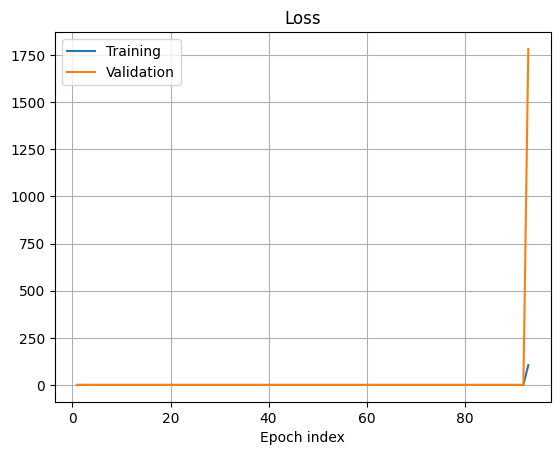

In [19]:
#(?) Create a folder called 'fig_folder'


os.makedirs('fig_folder', exist_ok=True)
fig_folder='fig_folder'

#
num_epochs = len(train_loss_list)
x_range = np.arange(num_epochs) + 1

# Plot training/validation loss
plt.figure()
plt.plot(x_range, train_loss_list, label='Training')
plt.plot(x_range, valid_loss_list, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch index')
plt.legend()
plt.grid()

#(?) Save the loss curves figure
plt.savefig(fig_folder + '/loss_plot_2layer.png')

**(?) Get the videos**

Requirements:
* Create a folder called 'pred_folder' and save the predictions in this folder
* Create a folder called 'video_folder' and save the videos in this folder

In [20]:
%cd corona

[WinError 2] Не удается найти указанный файл: 'corona'
C:\Users\Eugene\OneDrive\Китай


In [21]:
#(?) Create 'pred_folder' and 'video_folder'

os.makedirs('video_folder_2layer', exist_ok=True)
video_folder='video_folder_2layer'

os.makedirs('pred_folder_2layer', exist_ok=True)
pred_folder='pred_folder_2layer'

data_dir = file_list[0]

#
num_frames = 40
for file in file_list:
    D = loadmat('data/' + file)['D']
    D = torch.from_numpy(D).cfloat()
    L = torch.empty(0)
    S = torch.empty(0)
    for k in range(0, D.shape[-1] - num_frames + 1, num_frames):
        Dk = D[None, None, :, :, k:k + num_frames]
        Dk = torch.cat([torch.real(Dk), torch.imag(Dk)], dim=-1)
        Dk = Dk.to(device)

        with torch.no_grad():
            net.eval()
            Lk, Sk = net(Dk)

        Lk = Lk[..., :num_frames].cpu().detach().squeeze()
        Sk = Sk[..., :num_frames].cpu().detach().squeeze()

        L = torch.cat([L, Lk], dim=-1)
        S = torch.cat([S, Sk], dim=-1)

    savemat('%s/prediction_%s' % (pred_folder, file), {'L': L.numpy(), 'S': S.numpy()})

    D = torch.real(D[..., :L.shape[-1]])
    V = np.round(torch.cat([D, L, S], dim=1).numpy() * 255)
    array_to_gray_video(V, '%s/video_%s.mp4' % (video_folder, file[:-4]), fps=30)